# Исследование сервиса аренды самокатов GoFast.

 Предоставлены данные о некоторых пользователях из нескольких городов, а также об их поездках. Требуется проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки и с подпиской Ultra.
В основных данных есть информация о пользователях, их поездках и подписках.

### План проекта:
1. Загрузка и изучение данных 
2. Предобработка данных
3. Исследовательский анализ даннных
4. Подготовка данных и формирование выручки
5. Проверка гипотез
6. Решение задачи выснения оптимального количества промокодов
7. Итоговый вывод

### Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи — users_go.csv**

* user_id - уникальный идентификатор пользователя
* name	- имя пользователя
* age -	возраст
* city - город
* subscription_type - тип подписки (free, ultra)

**Поездки — rides_go.csv**

* user_id - уникальный идентификатор пользователя
* distance	- расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration	- продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date	- дата совершения поездки

**Подписки — subscriptions_go.csv**

* subscription_type - тип подписки
* minute_price	- стоимость одной минуты поездки по данной подписке
* start_ride_price	- стоимость начала поездки
* subscription_fee	- стоимость ежемесячного платежа

### Загрузка данных и изучение общей информации


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display
from scipy.stats import binom, norm
from math import sqrt
from scipy import stats as st

In [2]:
data_users = pd.read_csv('/data/users_go.csv', sep=',')
display(data_users.head())
data_rides_go = pd.read_csv('/data/rides_go.csv', sep=',')
display(data_rides_go.head())
data_subscriptions_go = pd.read_csv('/data/subscriptions_go.csv', sep=',')
display(data_subscriptions_go.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Согласно документации к данным:**

**data_users:**

- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

**data_rides_go:**

- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки


**data_subscriptions_go:**

- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

#### Посмотрим информацию по data, проверим на соответствие хорошему стилю, типы данных, наличие пропусков и аномалий:

In [3]:
display(data_users.info())
display(data_users.describe())
display(data_users.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В колонке user_id максимальное значение - 1534, а строк всего 1565 - значит есть дубликаты или ошибки - проверим.

Возраст пользователей в выборке - от 12 до 43 лет, в среднем - 25 лет

Тип данных соответствует необходимому в каждой колонке

Пропуски и аномалии не обнаружены

Всего строк - 1565

#### Посмотрим информацию по data_rides_go, проверим на соответствие хорошему стилю, типы данных, наличие пропусков и аномалий:

In [4]:
display(data_rides_go.info())
display(data_rides_go.describe())
display(data_rides_go.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


user_id     0
distance    0
duration    0
date        0
dtype: int64

В колонке user_id - минимум 1 и максимум 1534 соответствует данным в таблице data_users - значит всего выборка составляет 1534 пользователя.

Неправильный тип данных обнаружен в колонке date  - заменим на datetime

В колонке distance - аномально низкое значение 0,85 метров- стоит проверить данные - возможно это техническая ошибка, или данные занесли ошибочно, возможно могли ошибиться с мерой длины - 85 сантиметров -  невозможная продолжительность поездки

В колонке duration обнаружено аномально низкое значение -0.5 минуты - стоит проверить данные - возможно это техническая ошибка, или ошибка связана с попыткой использовать разряжающийся самокат, или ошибка в формировании данных - время указано в часах

Пропуски не обнаружены

Всего строк - 18068 

#### Посмотрим информацию по data_subscriptions_go, проверим на соответствие хорошему стилю, типы данных, наличие пропусков и аномалий:

In [5]:
display(data_subscriptions_go.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Тип данных соответствует необходимому в каждой колонке, пропусков, аномалий не обнаружено.

Количество строк - 2, с данными о тарифах на поездку с подпиской и без.

#### Вывод: 
Всего 3 таблицы с данными по 1534 пользователям. В таблице data_users указана информация о пользователях по категориям - город, возраст, тип подписки. В таблице data_rides_go  информация о пользователях по каждой поездке - расстоянию, продолжительности, дате - всего 18068 поездок. Также здесь обнаружены аномалии - проверим, и если целесообразно - исправим, и неправильный тип данных - исправим.
В таблице data_subscriptions_go  информация о тарифах на поездки - два варианта: с подпиской и без.
Пропуски в данных не обнаружены.
Требуется проверка на дубликаты в таблицах data_users и data_rides_go.




### Предобработка данных

#### Проверка на дубликаты - таблица data_users


In [6]:
print('Обнаружены дубликаты: ', data_users.duplicated().sum())
data_users.value_counts().head(35)

Обнаружены дубликаты:  31


user_id  name        age  city            subscription_type
209      Андрей      23   Омск            ultra                2
807      Александр   28   Екатеринбург    free                 2
611      Владимир    28   Омск            ultra                2
43       Стефания    22   Омск            ultra                2
737      Мелания     27   Ростов-на-Дону  free                 2
47       Юрий        28   Тюмень          ultra                2
1198     Демид       29   Ростов-на-Дону  free                 2
829      Федор       29   Пятигорск       free                 2
924      Мария       23   Пятигорск       free                 2
153      Герман      23   Москва          ultra                2
635      Герман      21   Москва          ultra                2
72       Никита      25   Москва          ultra                2
909      Константин  20   Екатеринбург    free                 2
908      Рустам      30   Тюмень          free                 2
136      Марсель     25   Тюме

Дубликатов 31 шт - удалим и проверим итог - должно остаться 1534 строки:

In [7]:
data_users = data_users.drop_duplicates(keep='first')
print(data_users.duplicated().sum())
data_users.info()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


#### Проверка на дубликаты - таблица data_rides_go

In [8]:
print('Обнаружены дубликаты: ', data_rides_go.duplicated().sum())

Обнаружены дубликаты:  0


Дубликаты не обнаружены.

#### Колонка date - заменим тип данных на datetime

In [9]:
data_rides_go['date'] = pd.to_datetime(data_rides_go['date'], format='%Y-%m-%d')
display(data_rides_go['date'].head())
data_rides_go.info()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


#### Создадим новый столбец с номером месяца на основе столбца date

In [10]:
data_rides_go['month'] = data_rides_go['date'].dt.month
display(data_rides_go.sort_values('date').head())
display(data_rides_go.sort_values('date', ascending=False).head())

data_rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
13113,1184,5322.175064,25.206214,2021-01-01,1
5445,582,2842.009269,22.180040,2021-01-01,1
12775,1159,3098.412934,18.300367,2021-01-01,1
17096,1467,1875.822964,16.039241,2021-01-01,1


,user_id,distance,duration,date,month
2576,272,4141.347535,28.706738,2021-12-30,12
3278,353,1133.292906,15.230583,2021-12-30,12
11752,1083,2952.365209,19.626301,2021-12-30,12
15704,1369,2879.604810,18.911052,2021-12-30,12
14115,1252,325.677862,9.302711,2021-12-30,12


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Данные представлены за период с 1.01.2021 - 30.12.2021

#### Проверим аномальные значения в колонках distance и duration

Рассмотрим их в совокупности: время затраченное на поездку должно быть адекватно. Особенно нас интересует продолжительность поездки менее 1 минуты. Проверим значения на графиках.

,user_id,distance,duration,date,month
11555,1069,0.855683,10.001902,2021-01-31,1
9541,925,2.570787,3.011018,2021-10-19,10
13690,1223,4.329506,4.008958,2021-05-22,5
8658,861,6.784447,6.015656,2021-07-21,7
7841,796,7.097072,10.026614,2021-11-26,11
8906,880,11.283615,2.035632,2021-03-28,3
8324,835,12.233115,4.034952,2021-09-19,9
13940,1240,15.000606,10.045002,2021-08-20,8
15626,1364,15.366168,6.057623,2021-08-22,8
11862,1091,15.630873,13.044660,2021-03-29,3


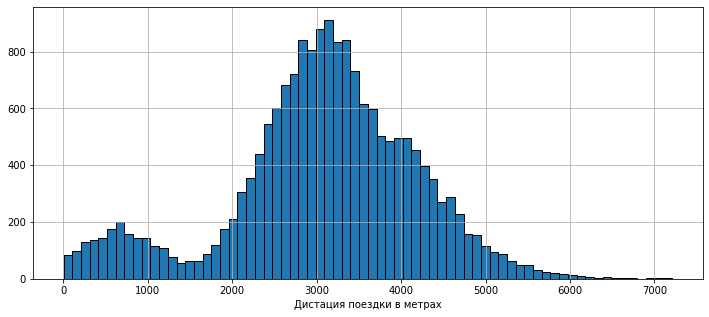

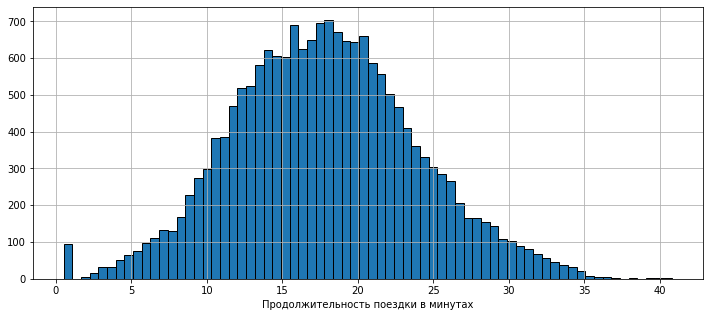

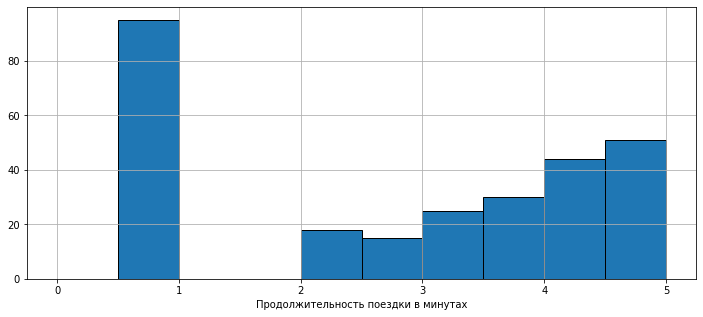

In [11]:
display(data_rides_go.sort_values('distance', ascending=True).head(20))
data_rides_go['distance'].hist(bins=70, edgecolor='black', figsize=(12,5))
plt.xlabel('Дистация поездки в метрах')
plt.show()
data_rides_go['duration'].hist(bins=70, edgecolor='black', figsize=(12,5))
plt.xlabel('Продолжительность поездки в минутах')
plt.show()
data_rides_go['duration'].hist(bins=10, edgecolor='black', range=(0, 5), figsize=(12,5))
plt.xlabel('Продолжительность поездки в минутах')
plt.show()

Аномалия 0.85м всего одна, причем время использования 10 минут, можем удалить чтобы не сбивать показания средних значений. Возможно это ошибка данных и дистанция - 850 метров, или пользователь передумал ехать/не смог воспользоваться самокатом/ самокат был не исправен/зависло приложение.
Также видим четкую аномалию в значении 0.5 минуты, таких поездок более 80 шт. рассмотрим подробнее, сравним с дистанцией:

In [12]:
data_rides_go = data_rides_go[(data_rides_go['distance'] > 1)]
display(data_rides_go.sort_values('distance', ascending=False).head(20))
display(data_rides_go.query('duration < 1').count()) 
display(data_rides_go.query('duration < 1').head(20))
print('Корреляция дистанции и времени поездки: {:.1%}'.format(data_rides_go['distance'].corr(data_rides_go['duration'])))

,user_id,distance,duration,date,month
16309,1411,7211.007745,0.500000,2021-04-15,4
16484,1422,7066.003772,23.619318,2021-02-12,2
15580,1361,6908.491343,23.816983,2021-03-27,3
17171,1471,6760.940067,32.043760,2021-08-03,8
17242,1477,6724.932981,0.500000,2021-01-12,1
10341,981,6671.969833,27.297078,2021-12-06,12
11385,1057,6601.197575,0.500000,2021-02-07,2
12086,1108,6538.937375,29.649276,2021-09-27,9
10915,1022,6535.386520,30.008799,2021-10-14,10
11319,1052,6503.600402,26.008309,2021-07-01,7


user_id     95
distance    95
duration    95
date        95
month       95
dtype: int64

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
6860,724,6225.520342,0.5,2021-12-16,12
6883,726,4452.491518,0.5,2021-03-01,3
7018,735,4406.954812,0.5,2021-04-13,4
7160,745,5286.167732,0.5,2021-08-17,8
7364,760,4881.391865,0.5,2021-08-29,8


Корреляция дистанции и времени поездки: 53.7%


Считаю наиболее вероятным что 0.5 минуты - это значения в часах - т е 30 минут. Корреляция почти 54%, можем заменить значения 0.5 средним значением по поездкам свыше 4000 метров


user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

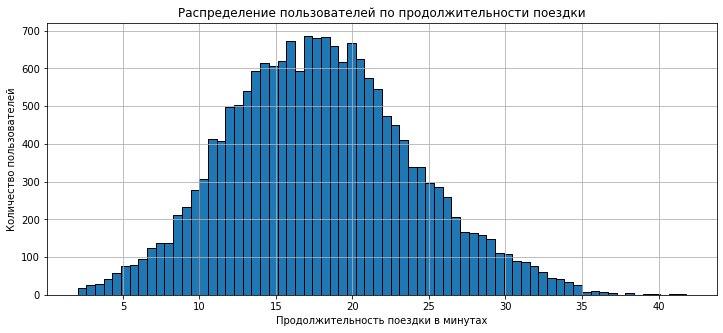

Корреляция дистанции и времени поездки: 59.1%


,user_id,distance,duration,month
count,18067.000000,18067.000000,18067.000000,18067.000000
mean,842.857420,3070.829888,17.958707,6.487076
std,434.743093,1116.628558,6.026152,3.437263
min,1.000000,2.570787,2.035632,1.000000
25%,487.000000,2543.347870,13.697389,4.000000
50%,889.000000,3133.674411,17.751427,6.000000
75%,1213.500000,3776.251372,21.824713,9.000000
max,1534.000000,7211.007745,41.811234,12.000000


In [13]:
mean_distanse =  data_rides_go['duration'].mean() / data_rides_go['distance'].mean()
data_rides_go.loc[data_rides_go['duration'] < 1, 'duration'] = (mean_distanse * data_rides_go['distance']) 
display(data_rides_go.query('duration < 1').count())
data_rides_go['duration'].hist(bins=70, edgecolor='black', figsize=(12,5))
plt.title("Распределение пользователей по продолжительности поездки")
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность поездки в минутах')
plt.show()
print('Корреляция дистанции и времени поездки: {:.1%}'.format(data_rides_go['distance'].corr(data_rides_go['duration'])))
display(data_rides_go.describe())

Теперь распределение данных по продолжительности поездки Пуассона - выглядит правдоподобно, среднее время в пути - 17,95 минут и средняя дистанция 3070 метров


In [14]:
data_rides_go['user_id'].nunique()

1534

#### Вывод:
Данные готовы к исследованию, дубликаты, аномалии устранены, типы данных исправлены на необходимые.
Всего в выборке данные по 1534 пользователям и их поездкам в количестве = 18067.

### Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:
3.1 частота встречаемости городов;
3.2 соотношение пользователей с подпиской и без подписки;
3.3 возраст пользователей;
3.4 расстояние, которое пользователь преодолел за одну поездку;
3.5 продолжительность поездок.

#### Изучим распределениие выборки по городам

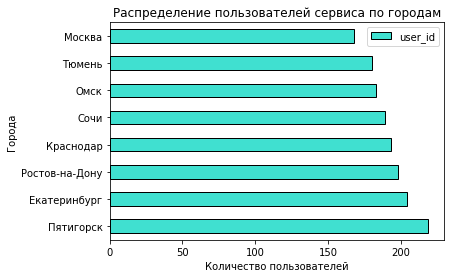

In [15]:
(data_users
  .pivot_table(index='city', values='user_id', aggfunc='count')
  .sort_values(by='user_id', ascending=False)
  .plot.barh(edgecolor='black', color='turquoise', grid=False)
)

plt.title("Распределение пользователей сервиса по городам")
plt.ylabel('Города')
plt.xlabel('Количество пользователей')
plt.show()

В выборке больше всего данных пользователей из Пятигорска и Екатеринбурга, и меньше всего  - из Москвы

#### Изучим соотношение пользователей с подпиской и без подписки

data_users['subscription_type'].hist(bins=3,figsize=(6,5), edgecolor='black',  grid=False, color='turquoise')
plt.xlabel('Распределение  пользователей с подпиской и без подписки')
plt.show()
data_price_top_10.plot(y = 'Количество объявлений', kind='pie', figsize = (8,8), legend=True)

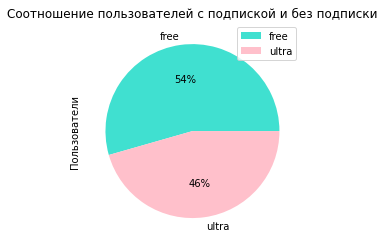

In [16]:
colors = ['turquoise', 'pink']
data_users.groupby(['subscription_type']).count().plot(
    kind='pie', y='user_id', autopct='%1.0f%%', colors=colors )

plt.title("Соотношение пользователей с подпиской и без подписки")
plt.ylabel('Пользователи')
plt.show()

Пользователей с подпиской на 16% меньше чем без подписки, всего по 835 и 699 пользователей соответственно

#### Изучим распределение пользователей по возрасту

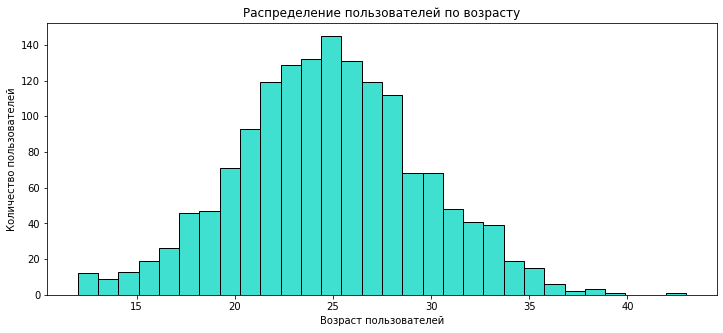

In [17]:
data_users['age'].hist(bins=30,figsize=(12,5), range=(12,43), edgecolor='black',  grid=False, color='turquoise')

plt.title("Распределение пользователей по возрасту")
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст пользователей')
plt.show()

In [18]:
data_users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


Распределение Пуассона, средний возраст - 25 лет, минимальный 12 лет, максимальный 43 года. Свыше 38 лет встречается крайне редко.
Можно было бы удалить выбросы, но не считаю это полезным в данном исследовании - их мало и выборка не такая большая чтобы этими данными можно было пренебречь.

#### Изучим расстояние, которое пользователь преодолел за одну поездку

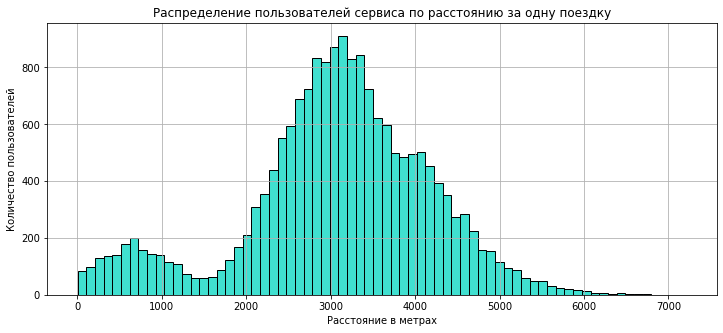

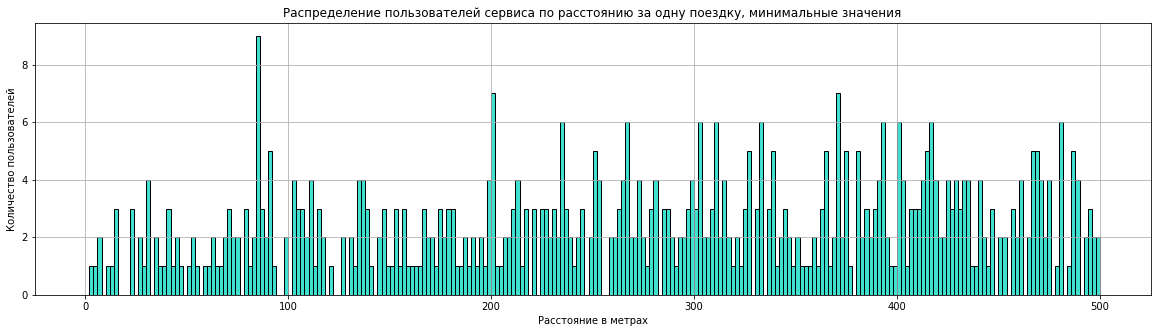

In [19]:
data_rides_go['distance'].hist(bins=70, edgecolor='black', figsize=(12,5), color='turquoise')
plt.title("Распределение пользователей сервиса по расстоянию за одну поездку")
plt.ylabel('Количество пользователей')
plt.xlabel('Расстояние в метрах')
plt.show()

data_rides_go['distance'].hist(bins=250, edgecolor='black', range=(0,500), figsize=(20,5), color='turquoise')
plt.title("Распределение пользователей сервиса по расстоянию за одну поездку, минимальные значения")
plt.ylabel('Количество пользователей')
plt.xlabel('Расстояние в метрах')
plt.show()


В среднем расстояние которое преоодолеват пользователь за одну поездку  - 3133м , максимум 7211.
Есть определенное количество очень коротких поездок - 2,5-200 метров - это вероятно связано с техническими неполадками/разрядкой аккумулятора/сменой планов/плохой погодой и другими возможными факторами.
И от 200 до 1500 метров - такие поездки вероятно связаны с практическими целями - побыстрее добраться куда-либо, например до метро.


#### Изучим продолжительность поездок

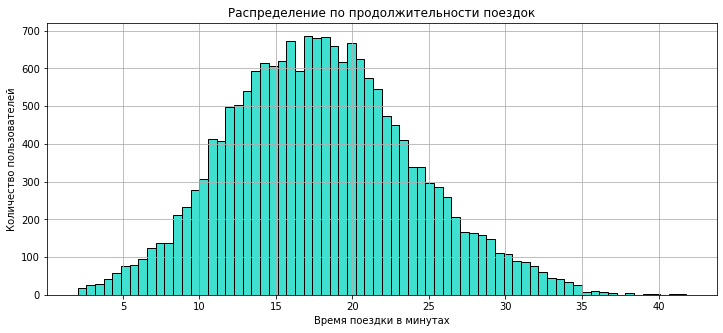

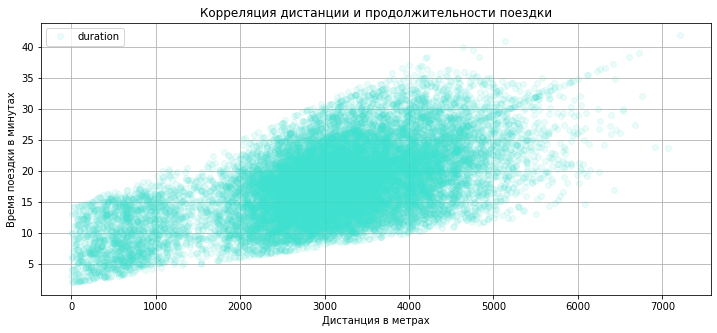

Корреляция дистанции и продолжительности поездки: 59.1%


In [20]:
data_rides_go['duration'].hist(bins=70, edgecolor='black', figsize=(12,5), color='turquoise')
plt.title("Распределение по продолжительности поездок")
plt.xlabel("Время поездки в минутах")
plt.ylabel("Количество пользователей")
plt.show()
(
    data_rides_go.pivot_table(index='distance', values='duration')
    .plot(grid=True, style='o', figsize=(12, 5), color='turquoise',  alpha=0.1)
)
plt.title("Корреляция дистанции и продолжительности поездки")
plt.xlabel("Дистанция в метрах")
plt.ylabel("Время поездки в минутах")
plt.show()

print('Корреляция дистанции и продолжительности поездки: {:.1%}'.format(data_rides_go['distance'].corr(data_rides_go['duration'])))

Распределение Пуассона, среднее время поездки 18 минут, есть очень короткие 2ух минутные и очень длинные - 40 минутные поездни, но их совсем мало. Обычно поездка занимает от 13 до 22 минут.
Расчитана и визуализирована корреляция - 59.1% между продолжительностью и временем поездки - что логично. 
Средняя скорость - 10 км в час

#### Вывод:
1. В выборке больше всего данных пользователей из Пятигорска и Екатеринбурга, и меньше всего - из Москвы
2. Пользователей с подпиской на 16% меньше чем без подписки, всего по 835 и 699 пользователей соответственно
3. Средний возраст - 25 лет, минимальный 12 лет, максимальный 43 года. Свыше 38 лет встречается крайне редко
4. В среднем расстояние которое преоодолеват пользователь за одну поездку  - 3133м , максимум 7211, небольшая часть коротких поездок обусловлена техническими проблемами и человеческим фактором.
5. Обычно поездка занимает от 13 до 22 минут. Корреляция между продолжительностью и временем поездки - 59.1%. Средняя скорость - 10 км в час

### Объединение данных

#### Объединим данные из таблиц data_users и data_rides_go в один датафрейм по столбцу user_id

In [21]:
summary_data = data_users.merge(data_rides_go, on ='user_id', how='left')
summary_data = summary_data.merge(data_subscriptions_go,on ='subscription_type', how='left')
summary_data.info()
summary_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18067 entries, 0 to 18066
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18067 non-null  int64         
 1   name               18067 non-null  object        
 2   age                18067 non-null  int64         
 3   city               18067 non-null  object        
 4   subscription_type  18067 non-null  object        
 5   distance           18067 non-null  float64       
 6   duration           18067 non-null  float64       
 7   date               18067 non-null  datetime64[ns]
 8   month              18067 non-null  int64         
 9   minute_price       18067 non-null  int64         
 10  start_ride_price   18067 non-null  int64         
 11  subscription_fee   18067 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Сравнили количество строк с количеством строк таблиц до объединения - 18067 и  18067. Объединение выполнено корректно

#### Создадим два датафрейма, один с данными пользователей, купивших подписку и второй с данными пользователей без подписки

In [22]:
data_users_ultra = summary_data[summary_data['subscription_type'] =='ultra']
data_users_free = summary_data[summary_data['subscription_type'] =='free']
display(data_users_ultra.head())
display(data_users_free.head())
print(data_users_ultra.info())
data_users_free.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB
None
<class 'pandas.core.frame.DataFrame

Пользователей с подпиской почти в 2 раза больше чем без подписки. 

#### Изучим зависимость расстояния и времени поездок для пользователей обеих категорий, для этого построим сводный график

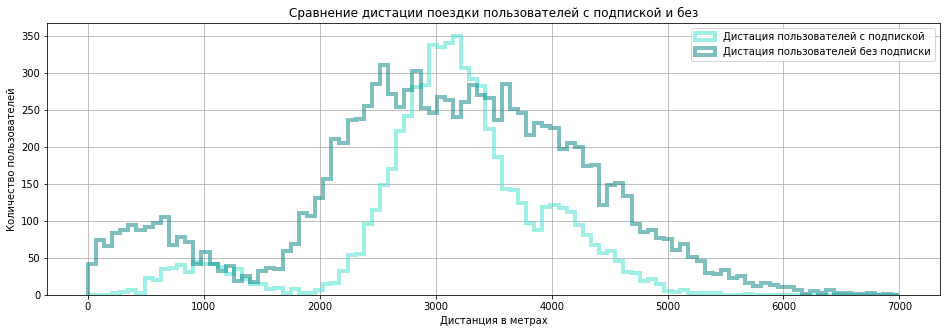

Средняя дистация поездки пользователей с подпиской: 3115
Средняя дистация поездки пользователей без подписки: 3046


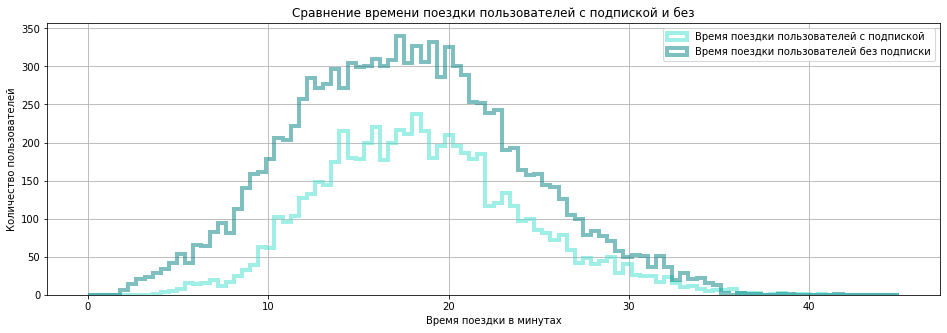

In [23]:
ax=data_users_ultra.plot(
    kind='hist',
    y='distance',
    histtype='step',
    range=(0, 7000),
    bins=100,
    linewidth=4,
    alpha=0.5,
    label='Дистация пользователей с подпиской',
    figsize=(16, 5),
    grid=True,
    color='turquoise',
    legend=True,
) 
data_users_free.plot(
    kind='hist',
    y='distance',
    histtype='step',
    range=(0, 7000),
    bins=100,
    linewidth=4,
    ax=ax,
    grid=True,
    alpha=0.5,
    color='teal',
    label='Дистация пользователей без подписки',
)  
plt.title("Сравнение дистации поездки пользователей с подпиской и без")
plt.xlabel("Дистанция в метрах")
plt.ylabel("Количество пользователей")
plt.show()

print('Средняя дистация поездки пользователей с подпиской:' , round(data_users_ultra['distance'].mean()))
print('Средняя дистация поездки пользователей без подписки:' ,round(data_users_free['distance'].mean()))


ax=data_users_ultra.plot(
    kind='hist',
    y='duration',
    histtype='step',
    range=(0, 45),
    bins=100,
    linewidth=4,
    alpha=0.5,
    label='Время поездки пользователей с подпиской',
    figsize=(16, 5),
    grid=True,
    color='turquoise',
    legend=True,
) 
data_users_free.plot(
    kind='hist',
    y='duration',
    histtype='step',
    range=(0, 45),
    bins=100,
    linewidth=4,
    ax=ax,
    grid=True,
    alpha=0.5,
    color='teal',
    label='Время поездки пользователей без подписки',
)  
plt.title("Сравнение времени поездки пользователей с подпиской и без")
plt.xlabel("Время поездки в минутах")
plt.ylabel("Количество пользователей")
plt.show()

#### Вывод:
Сравнив расстояние, которое преодолевают пользователи с подпиской и без подписки, можно выделить следущее:
   1. Пользователей с подпиской почти в 2 раза больше чем без подписки - 11567 и 6500 соответственно
   2. В среднем пользователи с подпиской ездят немного дальше чем пользователи без подписки, при этом распределение значений у пользователей без подписки шире - от 2-4 км, против 2,5-3,5 км
   3. По продолжительности поездок распределение практически одинаковое с учетом того что пользователей с подпиской почти в два раза меньше пользователей без подписки. В среднем поездка длится от 10 до 25 минут
    

### Подсчёт выручки

Округляем продолжительность каждой поездки:

In [24]:
summary_data['duration'] = np.ceil(summary_data['duration']) 
summary_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199




Агреггируем данные по user_id и month, переименовываем столбцы


In [25]:
summary_data_grouped = summary_data.groupby(['user_id','month','subscription_type']).agg({'distance':'sum', 'duration':'sum','user_id':'count','minute_price':'mean','start_ride_price':'mean','subscription_fee':'mean', })
summary_data_grouped.columns = ['distance','duration','number_trips','minute_price','start_ride_price','subscription_fee']
summary_data_grouped.head(10)

distance  duration  number_trips  \
user_id month subscription_type                                         
1       1     ultra               7027.511294      42.0             2   
        4     ultra                754.159807       7.0             1   
        8     ultra               6723.470560      46.0             2   
        10    ultra               5809.911100      32.0             2   
        11    ultra               7003.499363      56.0             3   
        12    ultra               6751.629942      28.0             2   
2       3     ultra              10187.723006      63.0             3   
        4     ultra               6164.381824      40.0             2   
        6     ultra               3255.338202      14.0             1   
        7     ultra               6780.722964      48.0             2   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
1       1     ultra                         6                 0   
        4     ultra                         6                 0   
        8     ultra                         6                 0   
        10    ultra                         6                 0   
        11    ultra                         6                 0   
        12    ultra                         6                 0   
2       3     ultra                         6                 0   
        4     ultra                         6                 0   
        6     ultra                         6                 0   
        7     ultra                         6                 0   

                                 subscription_fee  
user_id month subscription_type                    
1       1     ultra                           199  
        4     ultra                           199  
        8     ultra                           199  
        10    ultra                           199  
        11    ultra                           199  
        12    ultra                           199  
2       3     ultra                           199  
        4     ultra                           199  
        6     ultra                           199  
        7     ultra                           199

Создадим функцию для расчета выручки, которая считается так: (стоимость старта поездки × количество поездок)+ (стоимость одной минуты поездки × общая продолжительность всех поездок в минутах)+ стоимость подписки.
Передадим данные в новый столбец в датафрейме summary_data_grouped['revenue'].
Создадим датафреймы с пользователями с подпиской и без нее.

In [26]:
def revenue(row):
    start_ride_price = row['start_ride_price']
    number_trips = row['number_trips']
    minute_price = row['minute_price']
    duration = row['duration']
    subscription_fee = row['subscription_fee']
    revenue = (start_ride_price*number_trips)+(minute_price*duration)+subscription_fee
    return revenue
summary_data_grouped['revenue'] = summary_data_grouped.apply(revenue, axis=1)
display(summary_data_grouped.head())


distance  duration  number_trips  \
user_id month subscription_type                                        
1       1     ultra              7027.511294      42.0             2   
        4     ultra               754.159807       7.0             1   
        8     ultra              6723.470560      46.0             2   
        10    ultra              5809.911100      32.0             2   
        11    ultra              7003.499363      56.0             3   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
1       1     ultra                         6                 0   
        4     ultra                         6                 0   
        8     ultra                         6                 0   
        10    ultra                         6                 0   
        11    ultra                         6                 0   

                                 subscription_fee  revenue  
user_id month subscription_type                             
1       1     ultra                           199    451.0  
        4     ultra                           199    241.0  
        8     ultra                           199    475.0  
        10    ultra                           199    391.0  
        11    ultra                           199    535.0

### Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Нужно проверить следущие гипотезы:

#### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
Нулевая гипотеза (H0) - у пользователей с подпиской средний показатель продолжительности поездки такой же как у пользователей без подписки

Альтернативная гипотеза (H1) - у пользователей с подпиской средний показатель продолжительности поездки больше чем у пользователей без подписки

In [27]:
# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(data_users_ultra['duration'], data_users_free['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')


print()    
print('Средняя продолжительность поездки пользователей с подпиской:' , round(data_users_ultra['duration'].mean()),'минут')
print('Средняя продолжительность поездки пользователей без подписки:' ,round(data_users_free['duration'].mean()),'минут')

p-value: 7.941653287174216e-23
Отвергаем нулевую гипотезу

Средняя продолжительность поездки пользователей с подпиской: 19 минут
Средняя продолжительность поездки пользователей без подписки: 18 минут


Вывод: пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Нулевая гипотеза (H0) - пользователи с подпиской за одну сессию проезжают в среднем 3130 метров

Альтернативная гипотеза (H1) - пользователи с подпиской за одну сессию проезжают больше 3130 метров

In [28]:
# time_at_site = pd.read_csv('/datasets/user_time.csv')

optimal_distance = 3130 # оптимальное расстояние с точки зрения износа самоката 

alpha = 0.01 # уровень статистической значимости


results = st.ttest_1samp(
    data_users_ultra['distance'], 
    optimal_distance,
    alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')



p-значение: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


Вывод: у пользователей с подпиской средний показатель дистанции поездки примерно равен 3130, что является оптимальным значением с точки зрения износа самоката

#### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.
Нулевая гипотеза (H0) - помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.
Альтернативная гипотеза (H1) - помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [29]:

data_users_ultra_rev = summary_data_grouped.query('subscription_type == "ultra"')
data_users_free_rev = summary_data_grouped.query('subscription_type == "free"')
display(data_users_ultra_rev.head())
display(data_users_free_rev.head())

# задаём уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(
    data_users_ultra_rev['revenue'],
    data_users_free_rev['revenue'],
    alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

print()    
print('Средняя выручка от пользователей с подпиской:' , round(data_users_ultra_rev['revenue'].mean()))
print('Средняя выручка от пользователей без подписки:' ,round(data_users_free_rev['revenue'].mean()))


distance  duration  number_trips  \
user_id month subscription_type                                        
1       1     ultra              7027.511294      42.0             2   
        4     ultra               754.159807       7.0             1   
        8     ultra              6723.470560      46.0             2   
        10    ultra              5809.911100      32.0             2   
        11    ultra              7003.499363      56.0             3   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
1       1     ultra                         6                 0   
        4     ultra                         6                 0   
        8     ultra                         6                 0   
        10    ultra                         6                 0   
        11    ultra                         6                 0   

                                 subscription_fee  revenue  
user_id month subscription_type                             
1       1     ultra                           199    451.0  
        4     ultra                           199    241.0  
        8     ultra                           199    475.0  
        10    ultra                           199    391.0  
        11    ultra                           199    535.0

distance  duration  number_trips  \
user_id month subscription_type                                         
700     1     free                2515.690719      15.0             1   
        2     free               13446.659764      89.0             5   
        3     free                3798.334905      19.0             1   
        4     free                2984.551206      16.0             1   
        6     free                5927.650988      29.0             2   

                                 minute_price  start_ride_price  \
user_id month subscription_type                                   
700     1     free                          8                50   
        2     free                          8                50   
        3     free                          8                50   
        4     free                          8                50   
        6     free                          8                50   

                                 subscription_fee  revenue  
user_id month subscription_type                             
700     1     free                              0    170.0  
        2     free                              0    962.0  
        3     free                              0    202.0  
        4     free                              0    178.0  
        6     free                              0    332.0

p-value: 7.798421951532849e-26
Отвергаем нулевую гипотезу

Средняя выручка от пользователей с подпиской: 363
Средняя выручка от пользователей без подписки: 332


Вывод: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

#### Ответим на вопрос: "Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?"

Гипотеза о равенстве средних для зависимых (парных) выборок метод - scipy.stats.ttest_rel()

### Распределения

#### Отделу маркетинга GoFast поставили задачу: 
нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 1171 artists>

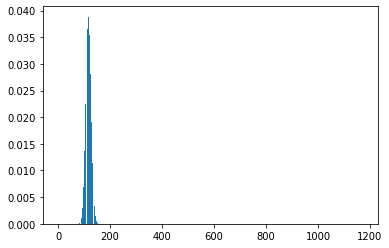

In [30]:
p = 0.1#вероятность что оплатят подписку после пробного периода
n = 1170# скольким пользователям отправим промокод

distr = []

for k in range(0, n + 1):
    values_SMI = binom.pmf(k, n, p)
    distr.append(values_SMI) #построим распределение вероятностей

plt.bar(range(0, n + 1), distr) #построим гистограмму распределения вероятностей

Проверим вероятность выполнения плана (минимум 100 клиентов продлят подписку)

In [31]:
d = n*p*(1-p) 
mu = n*p
sigma = d**0.5
distr = st.norm(mu, sigma) 

a = 100

# найдём и выведем на экран вероятности правых хвостов для a,
# округлив их до 5 цифр после запятой:
print('Вероятность того, что пользователь продлит подписку:',round(1- distr.cdf(a),5))


Вероятность того, что пользователь продлит подписку: 0.95121


Вывод: чтобы маркетологам выполнить план (100 пользователей подключат подписку с продлением) с веротностью более 95% нужно отправить 1170 промокодов пользователям

#### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении.
Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

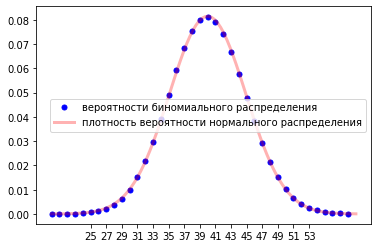

Условие выполняется


In [32]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 100
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 10 ст.отклонения бином.распределения
# до n*p плюс 10 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4* sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 2))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

In [33]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева не более 399,5 тыс.
result = distr.cdf(399500)
print(result)

0.15371708296369768


 Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей чуть больше 15%

### Итоговый Вывод

1. Всего 3 таблицы с данными по 1534 пользователям. В таблице data_users указана информация о пользователях по категориям - город, возраст, тип подписки. В таблице data_rides_go информация о пользователях по каждой поездке - расстоянию, продолжительности, дате - всего 18068 поездок. Также здесь обнаружены и исправлены аномалии, дубликаты, неправильный тип данных. В таблице data_subscriptions_go информация о тарифах на поездки - два варианта: с подпиской и без. Пропуски в данных не обнаружены.Всего в итоге в выборке данные по 1534 пользователям и их поездкам в количестве = 18067.
2. В выборке больше всего данных пользователей из Пятигорска и Екатеринбурга, и меньше всего - из Москвы
3. Пользователей с подпиской на 16% меньше чем без подписки, всего по 835 и 699 пользователей соответственно. Средний возраст - 25 лет, минимальный 12 лет, максимальный 43 года. Свыше 38 лет встречается крайне редко
4. В среднем расстояние которое преоодолеват пользователь за одну поездку - 3133м , максимум 7211, небольшая часть коротких поездок обусловлена техническими проблемами и человеческим фактором.
5. Обычно поездка занимает от 13 до 22 минут. Корреляция между продолжительностью и временем поездки - 59.1%. Средняя скорость - 10 км в час
6. Пользователей с подпиской почти в 2 раза больше чем без подписки - 11567 и 6500 соответственно
7. В среднем пользователи с подпиской ездят немного дальше чем пользователи без подписки, при этом распределение значений у пользователей без подписки шире - от 2-4 км, против 2,5-3,5 км
8. По продолжительности поездок распределение практически одинаковое с учетом того что пользователей с подпиской почти в два раза меньше пользователей без подписки. В среднем поездка длится от 10 до 25 минут
9. Пользователи с подпиской ездят на большие расстояния чем пользователи без подписки
10. У пользователей с подпиской средний показатель дистанции поездки примерно равен 3130, что является оптимальным значением с точки зрения износа самоката
11. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**В целом, рекомендуются меры по увеличению подписок у пользователей, высокая вероятность повышения прибыли.**